## Assimilation import

In [1]:
# Basic setting for Jupyter_notebook to import utils
import os
import sys

notebook_path = os.path.abspath("")
project_root = os.path.abspath(os.path.join(notebook_path, "../../"))

sys.path.append(project_root)

In [2]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from utils import folder_utils

In [3]:
''' 

@author: Ashesh Chattopadhyay
This is a hybird SPEnKF implementation with U-STNx as the backgroud forecast model.

More details in paper: https://gmd.copernicus.org/preprints/gmd-2021-71/

The github repository contains an jupyter notebook to train the U-STNx model with different values of "x"



'''

import numpy as np
import netCDF4 as nc
import scipy.io as sio

In [4]:
### This .mat file has been generated from the ERA5 lat-lon data ####
# file=sio.loadmat('ERA_grid.mat')
# lat=file['lat']
# lon=file['lon']

lat = np.linspace(50.0, 57.75, 32)  # latitude
lon = np.linspace(-6.0, 1.875, 64)  # longitude
# 3.Define the grid
# g_lon = np.linspace(-6.0, 1.875, 64)  # longitude
# g_lat = np.linspace(50.0, 57.75, 32)  # latitude
# # gridx, gridy = np.meshgrid(gridx, gridy)

In [5]:
# Input setting
# Example usage
country = "GB"
data_folder = "data"
data_read_category = "da_test_data"
data_test_category = "test_data"
data_save_category = "assimilated_data"
output_folder = "2022_data"


In [6]:
def get_era5_list(country, data_folder, data_category, output_folder):
    input_folder_path = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    nc_files = [
        f for f in os.listdir(input_folder_path) if f.endswith(".nc")
    ]
    return [
        os.path.join(input_folder_path, nc_file) for nc_file in nc_files
    ]  # list for era5 nc files path

In [7]:
########## This is the testing set #######

fileList_test=get_era5_list(country,data_folder,data_read_category,output_folder)
fileList_test

['F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_data\\GB_2022_data\\asos_kridge_2022.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_data\\GB_2022_data\\era5_pressure_level_2022_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_data\\GB_2022_data\\t2m_2022_regrid_filter.nc']

In [8]:
########### Ensure same normalization coefficient as trainig #######
M = 273.77817
sdev = 2.5819736

In [9]:
####### True data (noise free) for twin DA experiments ##########
## here can be modified 

F=nc.Dataset(fileList_test[1])
Z=np.asarray(F['t'])
TRUTH=Z

### Meshgrid for plotting ###
[qx,qy]=np.meshgrid(lon,lat)

In [10]:
##### Add noise to the truth to mimic observations####
#### Value 1 is 1*\sigma_Z. See more in paper #####
Z_rs = np.reshape(Z,[np.size(Z,0), int(np.size(Z,1)*np.size(Z,2))])
TRUTH = Z_rs
Z_rs = (Z_rs-M)/sdev
TRUTH = (TRUTH-M)/sdev
noise=1 # modify here

In [11]:
for k in range(1,np.size(Z_rs,0)):
    Z_rs[k-1,:]=Z_rs[k-1,:]+np.random.normal(0, noise, 2048)
print('length of initial condition',len(Z_rs[0,:]))

length of initial condition 2048


In [12]:
#### SPNEKF implementation following Tyrus Berry's implementation ######

def ENKF(x, n, P ,Q, R, obs, model, u_ensemble):
    print("obs\n")
    obs=np.reshape(obs,[n,1]) 
    print("x\n")
    x=np.reshape(x,[n,1])
    print("USV\n")
    [U,S,V]=np.linalg.svd(P)
    print("D\n")
    D=np.zeros([n,n])
    print("diagonal\n")
    np.fill_diagonal(D,S)
    print("sqrtP\n")
    sqrtP=np.dot(np.dot(U,np.sqrt(D)),U)
    print("ens1\n")
    ens=np.zeros([n,2*n])
    print("ens2\n")
    ens[:,0:n]=np.tile(x,(1,n)) + sqrtP
    print("ens3\n")
    ens[:,n:]=np.tile(x,(1,n)) - sqrtP
    ## forecasting step,dummy model

    for k in tqdm(range(0, np.size(ens,1))):

       u =  model.predict(np.reshape(ens[:,k],[1, 32, 64, 1]))

       u_ensemble[:,k]=np.reshape(u,(32*64,))



    ############################
    print("x_prior\n")
    x_prior = np.reshape(np.mean(u_ensemble,1),[n,1])
    print('shape pf x_prior',np.shape(x_prior))
    print('shape pf obs',np.shape(obs))
    print("cf_ens\n")
    cf_ens = ens - np.tile(x_prior,(1,2*n))
    print("P_prior\n")
    P_prior = np.dot(cf_ens,np.transpose(cf_ens))/(2*n - 1)+Q
    print("h_ens\n")
    h_ens = ens
    print("y_prior\n")
    y_prior=np.reshape(np.mean(h_ens,1),[n,1])
    ch_ens = h_ens - np.tile(y_prior,(1,2*n))
    print('shape pf y_prior',np.shape(y_prior))
    print("P_y\n")
    P_y = np.dot(ch_ens, np.transpose(ch_ens))/(2*n-1) + R
    print("P_xy\n")
    P_xy = np.dot(cf_ens, np.transpose(ch_ens)) /(2*n-1)
    print("K\n")
    K = np.dot(P_xy,np.linalg.inv(P_y))
    print("P\n")
    P = P_prior - np.dot(np.dot(K,P_y),np.transpose(K))
    print("x\n")
    x = x_prior + np.dot(K,(obs-y_prior))

    return x, P

In [13]:
def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights

In [14]:
from keras import backend as K
from keras.engine.topology import Layer

if K.backend() == 'tensorflow':
    import tensorflow as tf

    def K_meshgrid(x, y):
        return tf.meshgrid(x, y)

    def K_linspace(start, stop, num):
        return tf.linspace(start, stop, num)

else:
    raise Exception("Only 'tensorflow' is supported as backend")


class BilinearInterpolation(Layer):
    """Performs bilinear interpolation as a keras layer
    References
    ----------
    [1]  Spatial Transformer Networks, Max Jaderberg, et al.
    [2]  https://github.com/skaae/transformer_network
    [3]  https://github.com/EderSantana/seya
    """

    def __init__(self, output_size, **kwargs):
        self.output_size = output_size
        super(BilinearInterpolation, self).__init__(**kwargs)

    def get_config(self):
        return {
            'output_size': self.output_size,
        }

    def compute_output_shape(self, input_shapes):
        height, width = self.output_size
        num_channels = input_shapes[0][-1]
        return (None, height, width, num_channels)

    def call(self, tensors, mask=None):
        X, transformation = tensors
        output = self._transform(X, transformation, self.output_size)
        return output

    def _interpolate(self, image, sampled_grids, output_size):

        batch_size = K.shape(image)[0]
        height = K.shape(image)[1]
        width = K.shape(image)[2]
        num_channels = K.shape(image)[3]

        x = K.cast(K.flatten(sampled_grids[:, 0:1, :]), dtype='float32')
        y = K.cast(K.flatten(sampled_grids[:, 1:2, :]), dtype='float32')

        x = .5 * (x + 1.0) * K.cast(width, dtype='float32')
        y = .5 * (y + 1.0) * K.cast(height, dtype='float32')

        x0 = K.cast(x, 'int32')
        x1 = x0 + 1
        y0 = K.cast(y, 'int32')
        y1 = y0 + 1

        max_x = int(K.int_shape(image)[2] - 1)
        max_y = int(K.int_shape(image)[1] - 1)

        x0 = K.clip(x0, 0, max_x)
        x1 = K.clip(x1, 0, max_x)
        y0 = K.clip(y0, 0, max_y)
        y1 = K.clip(y1, 0, max_y)

        pixels_batch = K.arange(0, batch_size) * (height * width)
        pixels_batch = K.expand_dims(pixels_batch, axis=-1)
        flat_output_size = output_size[0] * output_size[1]
        base = K.repeat_elements(pixels_batch, flat_output_size, axis=1)
        base = K.flatten(base)

        # base_y0 = base + (y0 * width)
        base_y0 = y0 * width
        base_y0 = base + base_y0
        # base_y1 = base + (y1 * width)
        base_y1 = y1 * width
        base_y1 = base_y1 + base

        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = K.reshape(image, shape=(-1, num_channels))
        flat_image = K.cast(flat_image, dtype='float32')
        pixel_values_a = K.gather(flat_image, indices_a)
        pixel_values_b = K.gather(flat_image, indices_b)
        pixel_values_c = K.gather(flat_image, indices_c)
        pixel_values_d = K.gather(flat_image, indices_d)

        x0 = K.cast(x0, 'float32')
        x1 = K.cast(x1, 'float32')
        y0 = K.cast(y0, 'float32')
        y1 = K.cast(y1, 'float32')

        area_a = K.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = K.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = K.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = K.expand_dims(((x - x0) * (y - y0)), 1)

        values_a = area_a * pixel_values_a
        values_b = area_b * pixel_values_b
        values_c = area_c * pixel_values_c
        values_d = area_d * pixel_values_d
        return values_a + values_b + values_c + values_d

    def _make_regular_grids(self, batch_size, height, width):
        # making a single regular grid
        x_linspace = K_linspace(-1., 1., width)
        y_linspace = K_linspace(-1., 1., height)
        x_coordinates, y_coordinates = K_meshgrid(x_linspace, y_linspace)
        x_coordinates = K.flatten(x_coordinates)
        y_coordinates = K.flatten(y_coordinates)
        ones = K.ones_like(x_coordinates)
        grid = K.concatenate([x_coordinates, y_coordinates, ones], 0)

        # repeating grids for each batch
        grid = K.flatten(grid)
        grids = K.tile(grid, K.stack([batch_size]))
        return K.reshape(grids, (batch_size, 3, height * width))

    def _transform(self, X, affine_transformation, output_size):
        batch_size, num_channels = K.shape(X)[0], K.shape(X)[3]
        transformations = K.reshape(affine_transformation,
                                    shape=(batch_size, 2, 3))
        # transformations = K.cast(affine_transformation[:, 0:2, :], 'float32')
        regular_grids = self._make_regular_grids(batch_size, *output_size)
        sampled_grids = K.batch_dot(transformations, regular_grids)
        interpolated_image = self._interpolate(X, sampled_grids, output_size)
        new_shape = (batch_size, output_size[0], output_size[1], num_channels)
        interpolated_image = K.reshape(interpolated_image, new_shape)
        return interpolated_image

Using TensorFlow backend.
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [15]:
import tensorflow
import keras.backend as K
#from data_manager import ClutteredMNIST
#from visualizer import plot_mnist_sample
#from visualizer import print_evaluation
#from visualizer import plot_mnist_grid
import netCDF4
import numpy as np
from keras.layers import Input, Convolution2D, Convolution1D, MaxPooling2D, Dense, Dropout, \
                          Flatten, concatenate, Activation, Reshape, \
                          UpSampling2D,ZeroPadding2D
import keras
from keras.callbacks import History
history = History()

import keras
from keras.layers import Conv2D, Conv2DTranspose, Cropping2D, Concatenate, ZeroPadding2D
from keras.models import load_model

__version__ = 0.1


#### This is the circular convolution function. With/Without doesn't make much difference. If training is done with CConv2D then replace Convolution2D with CCvonv2D else leave it like this  #####
def CConv2D(filters, kernel_size, strides=(1, 1), activation='linear', padding='valid', kernel_initializer='glorot_uniform', kernel_regularizer=None):
    def CConv2D_inner(x):
        # padding (see https://www.tensorflow.org/api_guides/python/nn#Convolution)
        in_height = int(x.get_shape()[1])
        in_width = int(x.get_shape()[2])

        if (in_height % strides[0] == 0):
            pad_along_height = max(kernel_size[0] - strides[0], 0)
        else:
            pad_along_height = max(
                kernel_size[0] - (in_height % strides[0]), 0)
        if (in_width % strides[1] == 0):
            pad_along_width = max(kernel_size[1] - strides[1], 0)
        else:
            pad_along_width = max(kernel_size[1] - (in_width % strides[1]), 0)

        pad_top = pad_along_height // 2
        pad_bottom = pad_along_height - pad_top
        pad_left = pad_along_width // 2
        pad_right = pad_along_width - pad_left

        # left and right side for padding
        pad_left = Cropping2D(cropping=((0, 0), (in_width-pad_left, 0)))(x)
        pad_right = Cropping2D(cropping=((0, 0), (0, in_width-pad_right)))(x)

        # add padding to incoming image
        conc = Concatenate(axis=2)([pad_left, x, pad_right])

        # top/bottom padding options
        if padding == 'same':
            conc = ZeroPadding2D(padding={'top_pad': pad_top,
                                          'bottom_pad': pad_bottom})(conc)
        elif padding == 'valid':
            pass
        else:
            raise Exception('Padding "{}" does not exist!'.format(padding))

        # perform the circular convolution
        cconv2d = Conv2D(filters=filters, kernel_size=kernel_size,
                         strides=strides, activation=activation,
                         padding='valid',
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=kernel_regularizer)(conc)

        # return circular convolution layer
        return cconv2d
    return CConv2D_inner

from keras.layers import Input
from keras.models import Model
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense

# from utils import get_initial_weights
# from bilinear_interpolation_1x import BilinearInterpolation

In [16]:
##### Load model. DO not train. #####
def stn(input_shape=(32, 64, 1), sampling_size=(8, 16), num_classes=10):
    inputs = Input(shape=input_shape)
    conv1 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(pool2)
#     conv3 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv3)


    conv5 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv3)
#     conv5 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv5)
    
    locnet = Flatten()(conv5)
    locnet = Dense(500)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(200)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(100)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(50)(locnet)
    locnet = Activation('relu')(locnet)
    weights = get_initial_weights(50)
    locnet = Dense(6, weights=weights)(locnet)
    x = BilinearInterpolation(sampling_size)([inputs, locnet])


    up6 = keras.layers.Concatenate(axis=-1)([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(x)), conv2])
    conv6 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv6)

    up7 = keras.layers.Concatenate(axis=-1)([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv6)), conv1])
    conv7 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv7)



    conv10 = Convolution2D(1, 5, 5, activation='linear',border_mode='same')(conv7)

    model = Model(input=inputs, output=conv10)



    return model

In [17]:
# Input setting
# Example usage
country = "GB"
data_folder = "data"
data_read_category = "da_test_data"
data_test_category = "test_data"
data_save_category = "assimilated_data"
output_folder = "2022_weight_data"

In [18]:
def get_weight_list(country, data_folder, data_category, output_folder):
    input_folder_path = folder_utils.create_folder(
        country, data_folder, data_category, output_folder
    )
    nc_files = [
        f for f in os.listdir(input_folder_path) if f.endswith(".h5")
    ]
    return [
        os.path.join(input_folder_path, nc_file) for nc_file in nc_files
    ]  # list for era5 nc files path

In [19]:
weight_list = get_weight_list(country,data_folder,data_read_category,output_folder)

Folder 'F:\JuPyterNotebook\irp_ww721_bakcup\data\da_test_data\2022_weight_data\GB_2022_weight_data' created successfully.


In [20]:
weight_list

['F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_2.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_3.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_4.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_5.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_6.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_7.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_

In [21]:
best_weight = weight_list[4]

In [22]:
model = stn()
model.load_weights(best_weight) 
### This code performs DA at every 24 hrs with a model that is forecasting every hour. So lead will always be 1 ######

Instructions for updating:
Colocations handled automatically by placer.


D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  """
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  if __name__ == "__main__":
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  if sys.path[0]

## Calculation

In [23]:
import scipy.io as sio
import numpy as np
import xarray as xr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

In [24]:
era5_data = fileList_test[1]
era5_data 

'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_data\\GB_2022_data\\era5_pressure_level_2022_regrid_filter_850.nc'

In [31]:
random_seed = 42
np.random.seed(random_seed)

# Set time step
time_step = 144
dt = 1
steps = time_step // dt
count = 0

In [32]:
import netCDF4 as nc  # py37

In [33]:
# Load data
era5_value =netCDF4.Dataset(era5_data)

In [34]:
era5_t = np.asarray(era5_value["t"])
era5_t.shape

(8760, 32, 64)

In [35]:
# Select 50 initial conditions randomly
initial_conditions = 50
random_indices = np.random.choice(
    era5_t.shape[0] - 240,
    size=initial_conditions,
    replace=False,  # -240 to ensure enough range for prediction
)

pred_data = np.zeros([initial_conditions, steps, 32, 64])


In [36]:
random_indices

array([7499, 7310, 2571, 1084,  856, 4081, 2131, 1385, 4959, 3375, 4507,
       1670, 3617, 1623, 6847, 7028,  315, 3519, 6383, 8046, 4461, 4409,
       2111, 1057,  868,  700, 7690, 6716, 4560, 4015, 7070, 7327, 3668,
       3949, 8496, 1183,  794, 5794, 2487, 6686, 2802, 5962, 2483,  789,
        233, 4695,  429, 2614, 5686, 1281])

In [54]:
random_indices2 = list(range(50))
random_indices2

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [37]:
pred_data.shape

(50, 144, 32, 64)

In [63]:
for idx, start_t in tqdm(enumerate(random_indices2)):
    current_data = era5_t[start_t].reshape(1, 32, 64, 1)
    for s in range(steps):
        # Using the current data to predict the data for 24 hours later
        pred_data[idx, s] = model.predict(current_data).squeeze()
        # The predicted data is the current data for the next iteration
        current_data = pred_data[idx, s].reshape(1, 32, 64, 1)

50it [01:36,  1.94s/it]


In [56]:
pred_data.shape

(50, 144, 32, 64)

In [132]:
# # Calculate accuracy
# acc_values = []
# for i in tqdm(range(initial_conditions)):
#     for s in range(steps):
#         actual_data = era5_t[random_indices[i] + s * dt]
#         predicted_data = pred_data[i, s]

#         correlation, _ = pearsonr(actual_data.flatten(), predicted_data.flatten())
#         acc_values.append(correlation)

### Calculation

In [40]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [64]:
# Assuming 'steps' and 'initial_conditions' are predefined...

# Arrays to save accuracy, RMSE, and their standard deviations for each step
stepwise_acc_values = np.zeros(steps)
stepwise_rmse_values = np.zeros(steps)
stepwise_acc_std_values = np.zeros(steps)  # Array to save std dev of accuracy for each step
stepwise_rmse_std_values = np.zeros(steps)  # Array to save std dev of RMSE for each step

# Calculate accuracy, RMSE, and their standard deviations for each step
for s in tqdm(range(steps)):
    acc_values_for_this_step = []
    rmse_values_for_this_step = []
    for i in range(initial_conditions):
        actual_data = era5_t[random_indices[i] + s*dt]
        predicted_data = pred_data[i, s]

        correlation, _ = pearsonr(actual_data.flatten(), predicted_data.flatten())
        rmse = np.sqrt(mean_squared_error(actual_data, predicted_data))

        acc_values_for_this_step.append(correlation)
        rmse_values_for_this_step.append(rmse)

    stepwise_acc_values[s] = np.mean(acc_values_for_this_step)
    stepwise_rmse_values[s] = np.mean(rmse_values_for_this_step)
    stepwise_acc_std_values[s] = np.std(acc_values_for_this_step)  # Calculate std dev for accuracy
    stepwise_rmse_std_values[s] = np.std(rmse_values_for_this_step)  # Calculate std dev for RMSE

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 59.96it/s]


In [133]:
# Calculate accuracy
stepwise_acc_values = np.zeros(steps)
stepwise_rmse_values = np.zeros(steps)  # Array to save RMSE for each step
  # Calculate accuracy and RMSE for each step
for s in range(steps):
    acc_values_for_this_step = []
    rmse_values_for_this_step = []
    for i in tqdm(range(initial_conditions)):
        actual_data = era5_t[random_indices[i] + s*dt]
        predicted_data = pred_data[i, s]

        correlation, _ = pearsonr(actual_data.flatten(), predicted_data.flatten())
        rmse = np.sqrt(mean_squared_error(actual_data, predicted_data))

        acc_values_for_this_step.append(correlation)
        rmse_values_for_this_step.append(rmse)

    stepwise_acc_values[s] = np.mean(acc_values_for_this_step)
    stepwise_rmse_values[s] = np.mean(rmse_values_for_this_step)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6887.42it/s]


In [65]:
stepwise_acc_values

array([0.19784787, 0.20473748, 0.18696477, 0.35414661, 0.47367798,
       0.49443771, 0.4677195 , 0.51070726, 0.52162586, 0.51679011,
       0.49873265, 0.50793547, 0.50865665, 0.51681859, 0.52311678,
       0.52510405, 0.52157651, 0.51354655, 0.50955201, 0.5081266 ,
       0.51555178, 0.53167494, 0.5273118 , 0.51815321, 0.51487812,
       0.52458306, 0.4992959 , 0.50685827, 0.49637444, 0.51338974,
       0.49117589, 0.48867207, 0.48862877, 0.46329788, 0.46180841,
       0.45123446, 0.43042987, 0.43143392, 0.40209956, 0.39823208,
       0.43437655, 0.43632489, 0.4418309 , 0.43996654, 0.43928342,
       0.44117915, 0.43893999, 0.4220079 , 0.42594009, 0.44032484,
       0.43399408, 0.43547736, 0.43141139, 0.43827033, 0.45235928,
       0.4134947 , 0.39415129, 0.40187806, 0.38271179, 0.3867727 ,
       0.37786771, 0.38086827, 0.4008519 , 0.39685706, 0.41968004,
       0.43285389, 0.43823733, 0.44071368, 0.41801673, 0.4404823 ,
       0.4405828 , 0.45539815, 0.46763784, 0.47511144, 0.49805

In [66]:
stepwise_rmse_values

array([280.66501511, 276.40283881, 276.05627172, 275.86244687,
       275.79239177, 275.80068885, 275.76382378, 275.76689438,
       275.75672835, 275.73037281, 275.70487457, 275.70780847,
       275.73295226, 275.73216168, 275.70591454, 275.68460226,
       275.66028748, 275.6473639 , 275.63477902, 275.61838483,
       275.60541799, 275.59079943, 275.57768246, 275.53161242,
       275.49603587, 275.43591942, 275.42398087, 275.40860532,
       275.39424227, 275.40000215, 275.41260214, 275.42929269,
       275.41012006, 275.40629619, 275.38146111, 275.3694619 ,
       275.3579705 , 275.33378248, 275.30566754, 275.32750111,
       275.35170755, 275.38715919, 275.46380915, 275.49248594,
       275.53149199, 275.59832806, 275.62033887, 275.66300244,
       275.73383557, 275.81038564, 275.80951905, 275.83366336,
       275.85231547, 275.86436361, 275.86306528, 275.8823941 ,
       275.86563184, 275.83257785, 275.80344372, 275.81738058,
       275.79388153, 275.78727927, 275.79805072, 275.82

In [67]:
stepwise_acc_std_values

array([0.19073224, 0.23968891, 0.36645781, 0.42245572, 0.39252475,
       0.39369849, 0.37612106, 0.36825221, 0.36217697, 0.38124998,
       0.37644114, 0.38682694, 0.39552677, 0.37293582, 0.37111528,
       0.36714997, 0.34678544, 0.36510996, 0.35466544, 0.29991004,
       0.29446204, 0.2748301 , 0.26913664, 0.27870189, 0.28780177,
       0.27184102, 0.30635707, 0.29813107, 0.29608329, 0.31063243,
       0.30862326, 0.3296515 , 0.34623356, 0.390171  , 0.38119582,
       0.38887261, 0.38443356, 0.41590389, 0.40541765, 0.41811672,
       0.42244944, 0.43160847, 0.43457569, 0.45265518, 0.44815715,
       0.44413146, 0.43218709, 0.43127697, 0.42321995, 0.41585465,
       0.40430015, 0.40696573, 0.418262  , 0.41593369, 0.4176168 ,
       0.44365457, 0.45099537, 0.47674304, 0.49235343, 0.47962261,
       0.47880817, 0.47697112, 0.48012948, 0.46395406, 0.46928037,
       0.44984837, 0.44827967, 0.4318358 , 0.41704715, 0.39875596,
       0.39857164, 0.39290239, 0.38503574, 0.39007323, 0.39329

In [68]:
stepwise_rmse_std_values

array([3.41702043, 3.48509034, 3.52034273, 3.58636762, 3.62875901,
       3.68727728, 3.70844226, 3.75580474, 3.79594975, 3.87641541,
       3.9384897 , 3.98570399, 4.04891971, 4.11460841, 4.15818764,
       4.20975807, 4.24891284, 4.28698152, 4.33299628, 4.34544281,
       4.3848214 , 4.42309061, 4.50121927, 4.5504123 , 4.62263788,
       4.69250512, 4.73492927, 4.77417899, 4.79115185, 4.8281642 ,
       4.85001516, 4.88325063, 4.88419092, 4.90168944, 4.88881162,
       4.8978449 , 4.90434957, 4.92321427, 4.89779232, 4.87846826,
       4.85939545, 4.81178523, 4.80350523, 4.78023856, 4.74289804,
       4.73154341, 4.64464078, 4.5948026 , 4.60459614, 4.62584724,
       4.59903536, 4.62326106, 4.61240253, 4.58426063, 4.54871956,
       4.54276164, 4.52867885, 4.45612805, 4.42182683, 4.40420636,
       4.37215344, 4.33835455, 4.33505969, 4.34464254, 4.33262215,
       4.28583054, 4.27051937, 4.27633375, 4.28890633, 4.25912425,
       4.25268579, 4.26000891, 4.28666142, 4.31043577, 4.37621

In [51]:
stepwise_acc_values_1 = stepwise_acc_values
stepwise_rmse_values_1 = stepwise_rmse_values 
stepwise_acc_std_values_1 = stepwise_acc_std_values  # Array to save std dev of accuracy for each step
stepwise_rmse_std_values_1 =stepwise_rmse_std_values  # Array to save std dev of RMSE for each step


### PLot

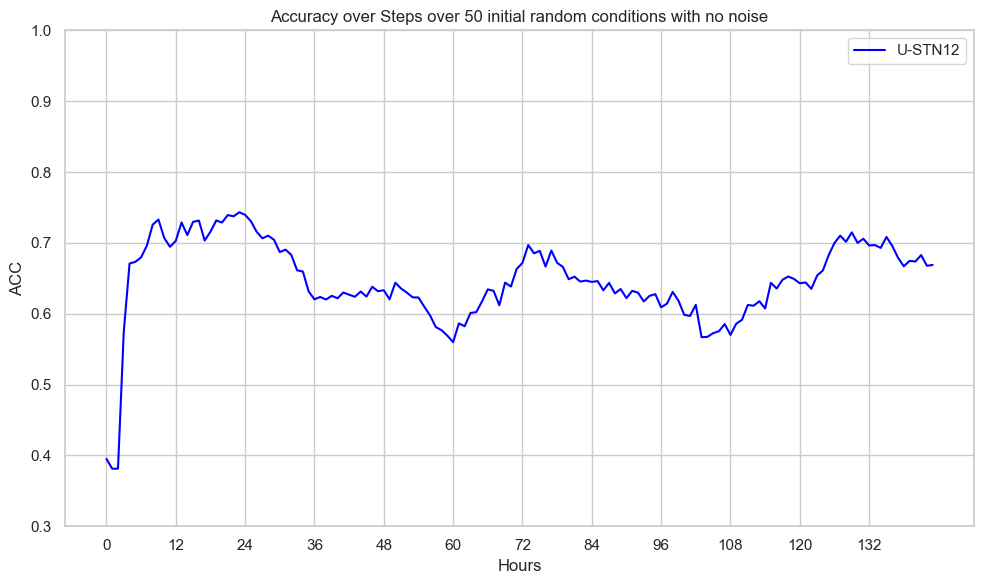

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data, replace with your own data in real applications
steps = 144
stepwise_acc_values = stepwise_acc_values_1  # For demonstration purposes
stepwise_acc_std_values = stepwise_acc_std_values_1  # For demonstration purposes

# x-axis represents steps, here we assume each step represents an hour
x = np.arange(steps)

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the line chart of accuracy over steps
plt.plot(x, stepwise_acc_values, label="U-STN12", color='blue')

# # Use fill_between to add shading to display the standard deviation
# plt.fill_between(x, stepwise_acc_values - stepwise_acc_std_values,
#                  stepwise_acc_values + stepwise_acc_std_values, color='blue', alpha=0.2)

# Set the y-axis range
plt.ylim(0.3, 1.0)

# Set the x-axis ticks
xticks = np.arange(0, steps, 12)
# yticks = np.arange(0.1, 0.6, 0.2)
plt.xticks(xticks)
# plt.yticks(yticks)

# Set title and axis labels
plt.title("Accuracy over Steps over 50 initial random conditions with no noise")
plt.xlabel("Hours")
plt.ylabel("Accuracy (ACC)")

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()


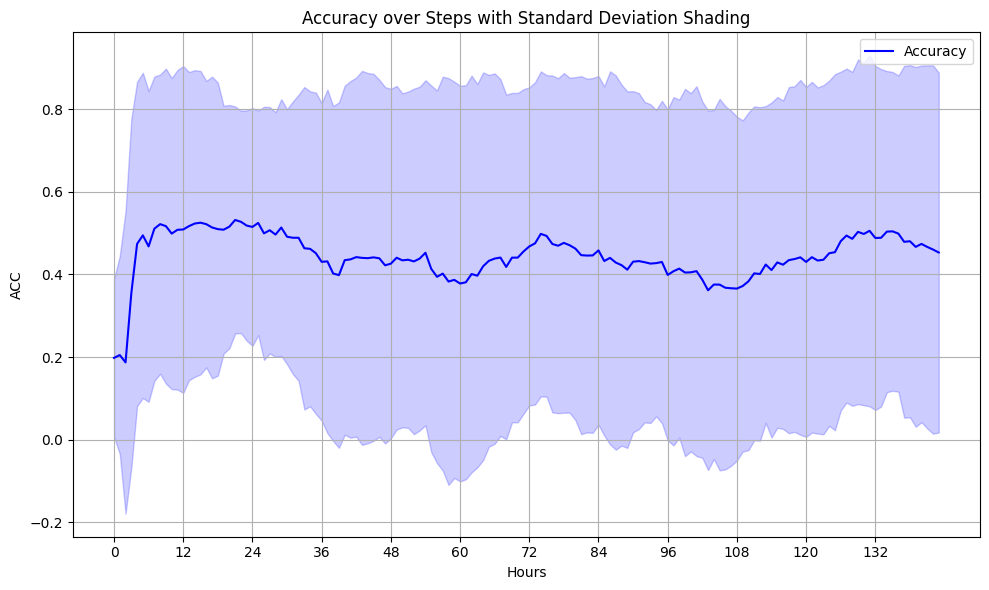

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data, replace with your own data in real applications
steps = 144
# stepwise_acc_values = stepwise_acc_values_1  # For demonstration purposes
# stepwise_acc_std_values = stepwise_acc_std_values_1  # For demonstration purposes

# x-axis represents steps, here we assume each step represents an hour
x = np.arange(steps)

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the line chart of accuracy over steps
plt.plot(x, stepwise_acc_values, label="Accuracy", color='blue')

# Use fill_between to add shading to display the standard deviation
plt.fill_between(x, stepwise_acc_values - stepwise_acc_std_values,
                 stepwise_acc_values + stepwise_acc_std_values, color='blue', alpha=0.2)

# Set the x-axis ticks
xticks = np.arange(0, steps, 12)
plt.xticks(xticks)

# Set title and axis labels
plt.title("Accuracy over Steps with Standard Deviation Shading")
plt.xlabel("Hours")
plt.ylabel("Accuracy (ACC)")

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()


### Calcilation end

In [48]:
tt = np.mean(acc_values)

In [49]:
tt

-0.04746939211496702

In [50]:
acc_values

[0.43382065439902645,
 0.5382613782793364,
 -0.1477817211645552,
 -0.09047264164290915,
 -0.3084115067874335,
 -0.46245111272081607,
 -0.7886719094854028,
 -0.600235716871462,
 -0.13299312567537813,
 -0.13846444393783414,
 -0.6417436289700011,
 -0.29983715333358213,
 0.4699766788210823,
 0.2302727987064994,
 0.3703579288782894,
 0.5752876848597315,
 0.8111433990563455,
 0.6773947195372136,
 0.4294019267505129,
 0.15319854392624888,
 0.49254047291791425,
 0.19761896579895966,
 0.36217261133806067,
 0.17033620967512972,
 0.24436458445392467,
 -0.07381896397809626,
 -0.5147746156869716,
 -0.11673728565665045,
 -0.5364915486006894,
 0.07252376343270964,
 -0.051623999221900196,
 -0.041338541898971466,
 -0.0821622787826248,
 -0.4152917417363947,
 -0.2621119705132494,
 -0.3367506601210079,
 -0.0382556163763909,
 0.033120378335521436,
 -0.532732932277114,
 -0.6274216879835409,
 0.4459726355909158,
 0.24255996184773262,
 0.3901193386569039,
 0.504687192876065,
 -0.4149074975197896,
 0.552326918

In [56]:
len(acc_values)

500

In [136]:
np.mean(stepwise_acc_values)

0.3465714533779885

In [137]:
np.mean(stepwise_rmse_values)

275.38828693709667

In [60]:
def calculate_acc(era5_data, stn_model_data, model_weight):
    # acc_value = 1 - np.mean(np.abs(input_value))

    # Load model
    model = stn()
    model.load_weights(model_weight)

    random_seed = 42
    np.random.seed(random_seed)

    # Set time step
    time_step = 240
    dt = 24
    steps = time_step // dt
    count = 0

    # Load data

    era5_value = netCDF4.Dataset(era5_data)
    era5_t = np.asarray(era5_value["t"])

    # Select 50 initial conditions randomly
    initial_conditions = 50
    random_indices = np.random.choice(
        era5_t.shape[0] - 240,
        size=initial_conditions,
        replace=False,  # -240 to ensure enough range for prediction
    )

    pred_data = np.zeros([initial_conditions, steps, 32, 64])

    for idx, start_t in tqdm(enumerate(random_indices)):
        current_data = era5_t[start_t].reshape(1, 32, 64, 1)
        for s in range(steps):
            # Using the current data to predict the data for 24 hours later
            pred_data[idx, s] = model.predict(current_data).squeeze()
            # The predicted data is the current data for the next iteration
            current_data = pred_data[idx, s].reshape(1, 32, 64, 1)

    # Calculate accuracy
    acc_values = []
    for i in tqdm(range(initial_conditions)):
        for s in range(steps):
            actual_data = era5_t[random_indices[i] + s * dt]
            predicted_data = pred_data[i, s]

            correlation, _ = pearsonr(actual_data.flatten(), predicted_data.flatten())
            acc_values.append(correlation)

    return acc_values

In [37]:
np.mean(acc_values)

-0.069554518191299

### final test

In [142]:
def calculate_acc_and_rmse(era5_data, model_weight,time_step, dt):
    # Load model
    model = stn()
    model.load_weights(model_weight)

    # Load data
    era5_value = netCDF4.Dataset(era5_data)
    era5_t = np.asarray(era5_value["t"])

    # Select 50 initial conditions randomly
    initial_conditions = 50
    random_indices = np.random.choice(
        era5_t.shape[0] - 240, size=initial_conditions, replace=False  # -240 to ensure enough range for prediction
    )

    # Parameters
#     dt = 24
#     time_step = 240
    steps = time_step // dt

    pred_data = np.zeros([initial_conditions, steps, 32, 64])
    stepwise_acc_values = np.zeros(steps)  # Array to save ACC for each step
    stepwise_rmse_values = np.zeros(steps)  # Array to save RMSE for each step

    for idx, start_t in tqdm(enumerate(random_indices)):
        current_data = era5_t[start_t].reshape(1, 32, 64, 1)
        for s in range(steps):
            # Using the current data to predict the data for 24 hours later
            pred_data[idx, s] = model.predict(current_data).squeeze()
            # The predicted data is the current data for the next iteration
            current_data = pred_data[idx, s].reshape(1, 32, 64, 1)

    # Calculate accuracy and RMSE for each step
    for s in range(steps):
        acc_values_for_this_step = []
        rmse_values_for_this_step = []
        for i in range(initial_conditions):
            actual_data = era5_t[random_indices[i] + s*dt]
            predicted_data = pred_data[i, s]

            correlation, _ = pearsonr(actual_data.flatten(), predicted_data.flatten())
            rmse = np.sqrt(mean_squared_error(actual_data, predicted_data))

            acc_values_for_this_step.append(correlation)
            rmse_values_for_this_step.append(rmse)

        stepwise_acc_values[s] = np.mean(acc_values_for_this_step)
        stepwise_rmse_values[s] = np.mean(rmse_values_for_this_step)

    return np.mean(stepwise_acc_values), np.mean(stepwise_rmse_values)

In [144]:
acc_value_list = []
rmse_value_list = []

for weight in tqdm(weight_list):
    t_stepwise_acc_values, t_stepwise_rmse_values = calculate_acc_and_rmse(era5_data, weight,48, 1)
    acc_value_list.append(t_stepwise_acc_values)
    rmse_value_list.append(t_stepwise_rmse_values)

  0%|                                                                                                      | 0/10 [00:00<?, ?it/s]D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  """
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  if __name__ == "__main__":
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: U

43it [00:48,  1.08s/it]
44it [00:50,  1.10s/it]
45it [00:51,  1.08s/it]
46it [00:52,  1.06s/it]
47it [00:53,  1.02s/it]
48it [00:54,  1.01s/it]
49it [00:55,  1.01s/it]
50it [00:56,  1.12s/it]
 40%|█████████████████████████████████████▌                                                        | 4/10 [04:08<06:09, 61.53s/it]D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  """
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update 

35it [00:42,  1.13s/it]
36it [00:43,  1.13s/it]
37it [00:44,  1.14s/it]
38it [00:46,  1.17s/it]
39it [00:47,  1.18s/it]
40it [00:48,  1.17s/it]
41it [00:49,  1.17s/it]
42it [00:50,  1.18s/it]
43it [00:51,  1.13s/it]
44it [00:52,  1.12s/it]
45it [00:54,  1.12s/it]
46it [00:55,  1.20s/it]
47it [00:56,  1.24s/it]
48it [00:58,  1.31s/it]
49it [00:59,  1.35s/it]
50it [01:01,  1.22s/it]
 80%|███████████████████████████████████████████████████████████████████████████▏                  | 8/10 [08:27<02:08, 64.09s/it]D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  """
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

In [145]:
acc_value_list

[-0.03742669794175735,
 0.3122759278419675,
 0.28800270528006466,
 0.2948718152389678,
 0.45301570933435226,
 0.14630610753847395,
 0.2797453503418368,
 0.2547808478135038,
 0.008683526914110668,
 0.007387322717884881]

In [146]:
rmse_value_list

[271.36541655285674,
 276.45794495368324,
 274.8070090978518,
 274.19715223864887,
 276.6224881082905,
 278.40601021024924,
 274.3520091316636,
 275.9003658934065,
 269.0577991253519,
 397.1648409574739]